In [19]:
from qiskit import * 

In [28]:
def c_set_reset(num_qubits: int, N: int) -> QuantumCircuit:
    bit_string = bin(N)[2:]
    bit_string = bit_string.rjust(num_qubits, "0")
    circ_n = QuantumRegister(num_qubits, name="N")
    c = QuantumRegister(1, name="c")
    quantum_circuit = QuantumCircuit(c, circ_n)
    quantum_circuit.name = "c-set-reset"
    quantum_circuit.x(c[0])
    for bit in range(len(bit_string)):
        if bit_string[bit] == "1":
            quantum_circuit.cx(c[0], circ_n[num_qubits-bit-1])
    quantum_circuit.x(c[0])
            
    return quantum_circuit
def set_reset_to(num_qubits: int, number: int) -> QuantumCircuit:
    num = QuantumRegister(num_qubits, name="num")
    quantum_curcuit = QuantumCircuit(num)
    quantum_curcuit.name = "set-reset"
    bit_string = bin(number)[2:]
    bit_string = bit_string.rjust(num_qubits, "0")
    for bit in range(len(bit_string)):
        if bit_string[bit] == "1":
            quantum_curcuit.x(num[num_qubits-bit-1])
    return quantum_curcuit

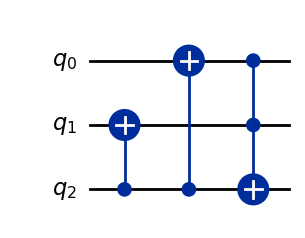

In [21]:
def qc_MAJ() -> QuantumCircuit:
    quantum_circuit = QuantumCircuit(3)
    quantum_circuit.name = "MAJ"
    quantum_circuit.cx(2, 1)
    quantum_circuit.cx(2, 0)
    quantum_circuit.ccx(0, 1, 2)
    return quantum_circuit

qc_MAJ().draw("mpl")

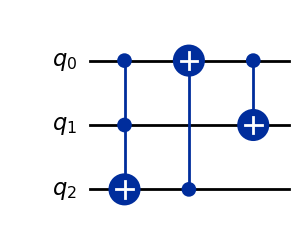

In [22]:
def qc_UMA(two_version: bool=True) -> QuantumCircuit:
    #if argument is true, implements the 2cnot version, else, implements the 3cnot version
    #check reference
    quantum_circuit = QuantumCircuit(3)
    quantum_circuit.name = "UMA"
    if two_version:
        quantum_circuit.ccx(0, 1, 2)
        quantum_circuit.cx(2, 0)
        quantum_circuit.cx(0, 1)
    else:
        quantum_circuit.x(1)
        quantum_circuit.cx(0, 1)
        quantum_circuit.ccx(0, 1, 2)
        quantum_circuit.x(1)
        quantum_circuit.cx(2, 0)
        quantum_circuit.cx(2, 1)
    return quantum_circuit

qc_UMA().draw("mpl")

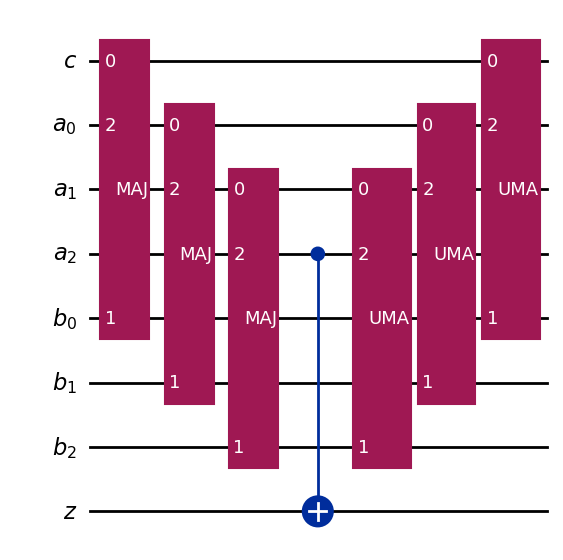

In [23]:
def adder_CDKM(num_qubits: int, modulo_2n: bool=False) -> QuantumCircuit:
    c = QuantumRegister(1, name="c")
    a = QuantumRegister(num_qubits, name="a")
    b = QuantumRegister(num_qubits, name="b")
    if not modulo_2n:
        z = QuantumRegister(1, name="z") 
        quantum_circuit = QuantumCircuit(c,a,b,z, name="Adder-CDKM")
    else:
        quantum_circuit = QuantumCircuit(c,a,b, name="Adder-CDKM-MOD2^n")
    
    quantum_circuit.append(qc_MAJ(), c[0:1] + b[0:1] + a[0:1])

    for i in range(1, num_qubits):
        quantum_circuit.append(qc_MAJ(), a[i-1:i] + b[i:i+1] + a[i:i+1])

    if not modulo_2n: quantum_circuit.cx(a[-1], z[0])
        
    for i in range(num_qubits-1, 0, -1):
        quantum_circuit.append(qc_UMA(), a[i-1:i] + b[i:i+1] + a[i:i+1])
        
    quantum_circuit.append(qc_UMA(), c[0:1] + b[0:1] + a[0:1])
    return quantum_circuit

adder_CDKM(3).draw("mpl")

In [24]:
from qiskit.quantum_info import Statevector

Statevector.from_label("1110100").evolve(adder_CDKM(3, True)).draw("latex")

<IPython.core.display.Latex object>

In [25]:
Statevector.from_label("00111110").evolve(adder_CDKM(3).inverse()).draw("latex")

<IPython.core.display.Latex object>

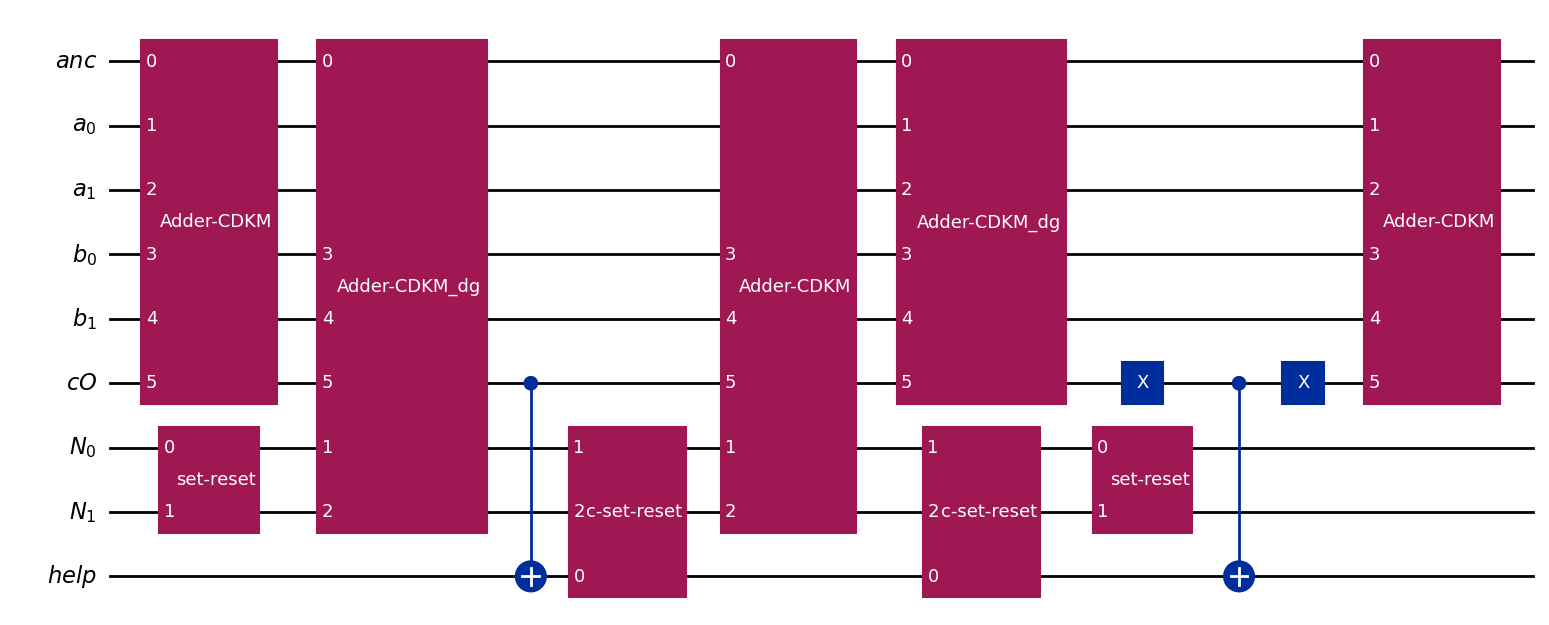

In [30]:
def mod_adder_CDKM_VBE(num_qubits: int, N: int) -> QuantumCircuit:
    anc = QuantumRegister(1, name="anc")
    a = QuantumRegister(num_qubits, name="a")
    b = QuantumRegister(num_qubits, name="b")
    cO = QuantumRegister(1, name="cO")
    n = QuantumRegister(num_qubits, name="N")
    help = QuantumRegister(1, name="help")
    quantum_circuit = QuantumCircuit(anc, a, b, cO, n, help, name=f"AdderMod{N}-CDKM-VBE")

    quantum_circuit.append(set_reset_to(num_qubits, N), n[:])

    quantum_circuit.append(adder_CDKM(num_qubits), anc[:] + a[:] + b[:] + cO[:])
    quantum_circuit.append(adder_CDKM(num_qubits).inverse(), anc[:] + n[:] + b[:] + cO[:])

    quantum_circuit.cx(cO[0], help[0])

    quantum_circuit.append(c_set_reset(num_qubits, N), help[:] + n[:])
    quantum_circuit.append(adder_CDKM(num_qubits), anc[:] + n[:] + b[:] + cO[:])
    quantum_circuit.append(c_set_reset(num_qubits, N), help[:] + n[:])

    quantum_circuit.append(adder_CDKM(num_qubits).inverse(), anc[:] + a[:] + b[:] + cO[:])

    quantum_circuit.x(cO[0])
    quantum_circuit.cx(cO[0], help[0])
    quantum_circuit.x(cO[0])

    quantum_circuit.append(adder_CDKM(num_qubits), anc[:] + a[:] + b[:] + cO[:])

    quantum_circuit.append(set_reset_to(num_qubits, N), n[:])

    return quantum_circuit

mod_adder_CDKM_VBE(2,3).draw("mpl")